# Self-Implemented LDA Analysis

In [108]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv('/home/aaronpham5504/personalFolder/MSA/Project/MSA-Vstatis/Data/Score.csv', encoding='ascii')
print(df.head(20))
print('Displayed first 20 rows of Score.csv')

    Delay_from_due_date  Num_of_Delayed_Payment  Num_Credit_Inquiries  \
0                   3.0                     7.0                   4.0   
1                   3.0                     7.0                   4.0   
2                   3.0                     7.0                   4.0   
3                   5.0                     4.0                   4.0   
4                   6.0                     4.0                   4.0   
5                   8.0                     4.0                   4.0   
6                   3.0                     8.0                   4.0   
7                   3.0                     6.0                   4.0   
8                   3.0                     4.0                   2.0   
9                   7.0                     1.0                   2.0   
10                  3.0                     1.0                   2.0   
11                  3.0                     3.0                   2.0   
12                  3.0                     1.0    

## Data Preprocessing

In [113]:
# 2. Kiểm tra và xử lý giá trị thiếu (nếu có)
df.dropna(inplace=True)  # Loại bỏ các dòng có giá trị NaN

# 3. Xác định biến mục tiêu và các cột cần encode
target_col = "Credit_Score"
categorical_cols = ["Credit_Mix", "Payment_Behaviour", "Payment_of_Min_Amount"]

# 4. Label Encoding cho biến mục tiêu và các cột phân loại
le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col])  # Encode Credit_Score

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Encode các cột phân loại khác
    label_encoders[col] = le

# 5. Tách biến đầu vào (X) và biến mục tiêu (y)
y_scaled = df[target_col]  # Nhãn phân loại
X = df.drop(columns=[target_col])  # Loại bỏ cột mục tiêu khỏi tập feature


# 6. Chuẩn hóa dữ liệu đầu vào
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Áp dụng Standard Scaling

# 7. Chuyển X về DataFrame để dễ thao tác
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_scaled_df = pd.DataFrame(y, columns=[target_col])

# # Hiển thị một số dòng sau khi tiền xử lý
# print(X_scaled_df.head())

# # Hiển thị biến mục tiêu
# print("Label Encoded Target Variable:")
# print(y.head())

# 8. export X_scaled_df về file CSV
X_scaled_df.to_csv('/home/aaronpham5504/personalFolder/MSA/Project/MSA-Vstatis/Data/Score_X.csv', index=False)
y_scaled_df.to_csv('/home/aaronpham5504/personalFolder/MSA/Project/MSA-Vstatis/Data/Score_y.csv', index=False)

# 9. Split data thành train và test set
target_samples = 17823

# Create the undersampler
undersampler = RandomUnderSampler(sampling_strategy={0: target_samples, 1: target_samples, 2: target_samples})

# Apply undersampling
X_resampled, y_resampled = undersampler.fit_resample(X_scaled, y_scaled)

# Check the new class distribution
print("Resampled dataset shape:", Counter(y_resampled))

class_counts = Counter(y_resampled)
print("Number of 0s:", class_counts[0])
print("Number of 1s:", class_counts[1])
print("Number of 2s:", class_counts[2])

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


Resampled dataset shape: Counter({0: 17823, 1: 17823, 2: 17823})
Number of 0s: 17823
Number of 1s: 17823
Number of 2s: 17823


## Within-class Variance

In [75]:
def calculate_within_class_scatter(X, y, num_classes):
    """
    Tính ma trận tán xạ nội tại (SW).

    Args:
        X (list of lists): Ma trận dữ liệu đầu vào (mẫu x đặc trưng).
        y (list): Vector nhãn lớp tương ứng.
        num_classes (int): Số lượng lớp.

    Returns:
        numpy.ndarray: Ma trận tán xạ nội tại SW.
    """
    X = np.array(X)
    SW = np.zeros((X.shape[1], X.shape[1]))  # SW: Within-class scatter matrix

    for k in range(1, num_classes + 1):  # k: Class index
        X_k = X[np.array(y) == k]  # X_k: Samples in class k
        if len(X_k) > 0:
            m_k = np.mean(X_k, axis=0)  # m_k: Mean vector of class k
            diff = X_k - m_k  # (x_i - m_k) for all samples in class k
            S_k = diff.T @ diff  # S_k = Σ (x_i - m_k)(x_i - m_k)^T
            SW += S_k  # SW += S_k
    return SW

## Between Class Variance

In [73]:
def calculate_between_class_scatter(X, y, num_classes):
    """
    Tính ma trận tán xạ ngoại tại (SB).

    Args:
        X (list of lists): Ma trận dữ liệu đầu vào.
        y (list): Vector nhãn lớp.
        num_classes (int): Số lượng lớp.

    Returns:
        numpy.ndarray: Ma trận tán xạ ngoại tại SB.
    """
    X = np.array(X)
    m = np.mean(X, axis=0)  # m: Overall mean vector
    SB = np.zeros((X.shape[1], X.shape[1]))  # SB: Between-class scatter matrix

    for k in range(1, num_classes + 1):  # k: Class index
        X_k = X[np.array(y) == k]  # X_k: Samples in class k
        N_k = len(X_k)  # N_k: Number of samples in class k
        if N_k > 0:
            m_k = np.mean(X_k, axis=0)  # m_k: Mean vector of class k
            diff = (m_k - m).reshape(-1, 1)  # (m_k - m)
            SB += N_k * (diff @ diff.T)  # SB += N_k * (m_k - m)(m_k - m)^T
    return SB

## LDA Objective Function

In [51]:
def lda_objective_function(W, SW, SB):
    """
    Tính giá trị của hàm mục tiêu LDA cho ma trận chiếu W.

    Args:
        W (numpy.ndarray): Ma trận chiếu (d x m).
        SW (numpy.ndarray): Ma trận tán xạ nội tại (d x d).
        SB (numpy.ndarray): Ma trận tán xạ ngoại tại (d x d).

    Returns:
        float: Giá trị của hàm mục tiêu.
    """
    WT_SW_W = np.dot(W.T, np.dot(SW, W))
    WT_SB_W = np.dot(W.T, np.dot(SB, W))

    # Kiểm tra xem WT_SW_W có khả nghịch không
    try:
        WT_SW_W_inv = np.linalg.inv(WT_SW_W)
    except np.linalg.LinAlgError:
        print("Ma trận WT_SW_W là suy biến, không thể tính nghịch đảo.")
        return -np.inf  # Trả về giá trị âm vô cùng để biểu thị trường hợp không hợp lệ

    objective_value = np.trace(np.dot(WT_SW_W_inv, WT_SB_W))
    return objective_value

## Optimized Problem

In [52]:
def solve_lda(X, y, num_classes, num_components):
    """
    Tìm ma trận chiếu W tối ưu bằng cách giải bài toán giá trị riêng tổng quát.

    Args:
        X (list of lists): Ma trận dữ liệu đầu vào.
        y (list): Vector nhãn lớp.
        num_classes (int): Số lượng lớp.
        num_components (int): Số lượng chiều của không gian chiếu (<= num_classes - 1).

    Returns:
        numpy.ndarray: Ma trận chiếu W (các vector riêng tương ứng với eigenvalues lớn nhất).
    """
    X = np.array(X)
    SW = calculate_within_class_scatter(X, y, num_classes)
    SB = calculate_between_class_scatter(X, y, num_classes)

    try:
        # Dùng nghịch đảo giả để tránh lỗi suy biến
        SW_inv = np.linalg.inv(SW)
        matrix_for_eigen = SW_inv @ SB

        # Tìm eigenvalues và eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(matrix_for_eigen)

        # Sắp xếp eigenvalues theo thứ tự giảm dần và chọn num_components eigenvectors tương ứng
        sorted_indices = np.argsort(eigenvalues)[::-1]  # Sắp xếp giảm dần
        W = eigenvectors[:, sorted_indices[:num_components]]  # Chọn đúng số cột
        return W
    
    except Exception as e:
        print("Lỗi khi tính toán giá trị riêng:", str(e))
        return None


## Classification

In [7]:

def predict_lda(X_new, W, X_train, y_train):
    """
    Dự đoán nhãn lớp cho dữ liệu mới X_new sau khi đã huấn luyện mô hình LDA.

    Args:
        X_new (numpy.ndarray): Ma trận dữ liệu mới cần phân lớp (n_samples x n_features).
        W (numpy.ndarray): Ma trận chiếu LDA (n_features x n_components).
        X_train (numpy.ndarray): Ma trận dữ liệu huấn luyện (n_train_samples x n_features).
        y_train (numpy.ndarray): Vector nhãn lớp của dữ liệu huấn luyện (n_train_samples).

    Returns:
        numpy.ndarray: Vector các nhãn lớp dự đoán cho X_new.
    """
    # 1. Chiếu dữ liệu mới vào không gian LDA
    X_new_projected = np.dot(X_new, W)
    X_train_projected = np.dot(X_train, W)

    # 2. Tính trung bình của mỗi lớp trong không gian LDA (từ dữ liệu huấn luyện)
    class_means_projected = {}
    unique_classes = np.unique(y_train)
    for class_label in unique_classes:
        X_class_projected = X_train_projected[y_train == class_label]
        if X_class_projected.shape[0] > 0:
            class_means_projected[class_label] = np.mean(X_class_projected, axis=0)
        else:
            class_means_projected[class_label] = None

    # 3. Phân lớp dữ liệu mới dựa trên khoảng cách đến trung bình các lớp
    predictions = []
    for sample_projected in X_new_projected:
        best_class = None
        min_distance = np.inf
        for class_label, mean_projected in class_means_projected.items():
            if mean_projected is not None:
                distance = np.linalg.norm(sample_projected - mean_projected)
                if distance < min_distance:
                    min_distance = distance
                    best_class = class_label
        predictions.append(best_class)

    return np.array(predictions)

## Testing

In [67]:
from sklearn.datasets import make_classification
import pandas as pd

# Tạo dữ liệu giả lập phù hợp cho LDA đa lớp
X_train, y_train = make_classification(
    n_samples=300,        # 300 mẫu dữ liệu
    n_features=5,         # 5 đặc trưng (>= số lớp - 1 để LDA hoạt động tốt)
    n_informative=3,      # 3 đặc trưng thực sự hữu ích
    n_redundant=1,        # 1 đặc trưng dư thừa (có thể không cần)
    n_classes=4,          # 4 lớp để kiểm tra LDA đa lớp
    n_clusters_per_class=1,
    class_sep=2.0,        # Độ phân tách giữa các lớp để dễ phân biệt
    random_state=42
)

# Đưa vào DataFrame để dễ quan sát
df_X = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(X.shape[1])])
df_y = pd.DataFrame(y, columns=['Label'])

# Kiểm tra dữ liệu
df_X.head(), df_y['Label'].value_counts()


(   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
 0   1.129324  -1.867338  -0.516312   1.462295   1.870768
 1  -0.828194   3.897921   3.202122   3.233074   4.012844
 2  -0.495866  -2.463371  -0.135822   3.050568  -3.438295
 3   0.618687  -2.488682  -0.536070   2.389235   2.906874
 4   0.204549  -2.029105  -0.549130   1.632037   2.203497,
 Label
 1    75
 3    75
 0    75
 2    75
 Name: count, dtype: int64)

In [77]:
SW = calculate_within_class_scatter(X_train, y_train, 4)
SB = calculate_between_class_scatter(X_train, y_train, 4)

print("SW shape:", SW.shape)
print("SB shape:", SB.shape)

W = solve_lda(X_train, y_train, 4, 3)
print("W shape:", W.shape)

J_w = lda_objective_function(W, SW, SB) 
print(J_w)

SW shape: (5, 5)
SB shape: (5, 5)
W shape: (5, 3)
7.09602327302466


In [79]:
X_train = StandardScaler().fit_transform(X_train)
print(X_train)  
W = solve_lda(X_train, y_train, num_classes=4, num_components=3)
print("W shape:", W.shape)  # Phải ra (5,3)
W

[[ 1.11130281e+00 -4.40814034e-01 -2.67492682e-01  1.97559026e-01
   7.19634073e-01]
 [-9.14932597e-01  2.38799046e+00  2.34537520e+00  1.08077402e+00
   1.59477828e+00]
 [-5.70938714e-01 -7.33266160e-01 -1.29843453e-04  9.89745249e-01
  -1.44938029e+00]
 ...
 [-1.67429832e+00  8.86941301e-02  1.29585373e-01  1.26392462e-01
   1.12244407e-01]
 [ 3.55267221e-03  1.79510086e+00  1.84687779e+00  9.76255289e-01
   1.21911287e+00]
 [-1.09858485e-01 -1.25224931e+00 -3.39372024e-01  1.33545590e+00
   1.51573132e+00]]
W shape: (5, 3)


array([[ 0.00088144,  0.00217046, -0.06893986],
       [-0.50949581,  0.73146028, -0.08902481],
       [-0.19875601, -0.61241625, -0.13690663],
       [-0.45670721, -0.15720575,  0.8688742 ],
       [-0.70166075, -0.25533083, -0.46220784]])

In [54]:
# Chiếu dữ liệu gốc xuống không gian LDA
X_projected = X_train @ W
X_projected

array([[-3.16427390e-01, -3.71011235e-01, -1.61714720e-01],
       [-3.29622563e+00, -2.68711485e-01, -2.68674840e-01],
       [ 9.38068064e-01, -3.23036921e-01,  1.63453612e+00],
       [-6.66967058e-01, -7.67419932e-01,  1.09821533e-01],
       [-4.06294313e-01, -4.65042777e-01, -7.47695332e-02],
       [ 1.51673149e+00,  9.41246153e-01, -7.28284340e-01],
       [ 6.81500890e-01, -6.99855754e-02,  7.09078538e-01],
       [-4.17827765e-01, -5.87288688e-01,  7.15835576e-03],
       [-1.68383918e+00,  1.96617297e-01, -5.92040189e-01],
       [ 3.45958723e-01, -1.27719717e-01,  4.79481830e-01],
       [ 4.64955208e-01, -6.48447399e-02,  3.31869343e-01],
       [ 1.77423236e+00,  1.20102168e+00, -9.11241963e-01],
       [ 2.23650813e+00,  9.89376026e-01, -1.05516894e+00],
       [ 1.82760434e+00,  1.23069977e+00, -1.09247206e+00],
       [ 1.35349268e+00,  6.92054917e-01, -4.12901611e-01],
       [ 1.48608220e+00,  6.77428033e-01, -4.47312290e-01],
       [ 1.18381787e+00, -2.63276461e-01

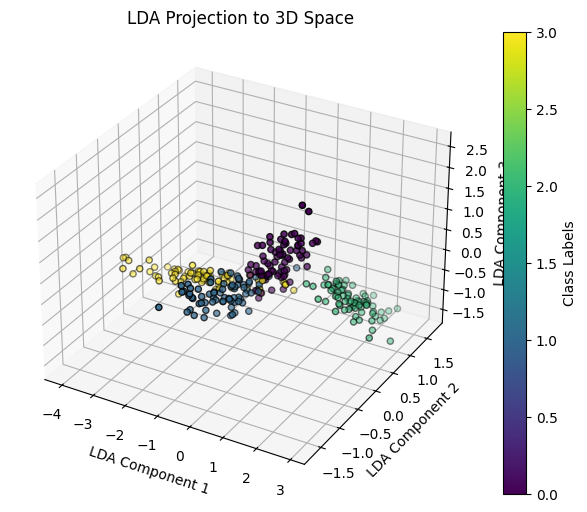

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_projected[:, 0], X_projected[:, 1], X_projected[:, 2], c=y_train, cmap='viridis', edgecolor='k')

ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
plt.colorbar(scatter, label="Class Labels")
plt.title("LDA Projection to 3D Space")
plt.show()

# Library LDA Analysis

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_sklearn = LinearDiscriminantAnalysis(n_components=3)
X_projected_sklearn = lda_sklearn.fit_transform(X_train, y_train)

W_sklearn = lda_sklearn.scalings_  # Ma trận trọng số của sklearn
print("W từ sklearn:\n", W_sklearn)

W từ sklearn:
 [[-0.05704978  0.06036026  0.0878706 ]
 [ 0.30440002  1.06926771  0.51271737]
 [ 0.68782849  0.17291254  0.7581664 ]
 [ 0.92111942 -1.76884387  0.40278408]
 [ 1.01609539  0.82289791 -1.57942842]]


In [60]:
print("Sai số giữa W của bạn và sklearn:")
print(np.abs(W - W_sklearn))

Sai số giữa W của bạn và sklearn:
[[0.05793122 0.0581898  0.15681046]
 [0.81389582 0.33780743 0.60174217]
 [0.88658451 0.7853288  0.89507303]
 [1.37782663 1.61163812 0.46609011]
 [1.71775615 1.07822874 1.11722058]]


In [61]:
X_projected_custom = X_train @ W  # Chiếu dữ liệu bằng W của bạn
X_projected_sklearn = X_train @ W_sklearn  # Chiếu dữ liệu bằng W của sklearn

diff = np.linalg.norm(X_projected_custom - X_projected_sklearn, axis=1)
print("Sai số trung bình giữa hai phép chiếu:", np.mean(diff))


Sai số trung bình giữa hai phép chiếu: 3.8292510179042423


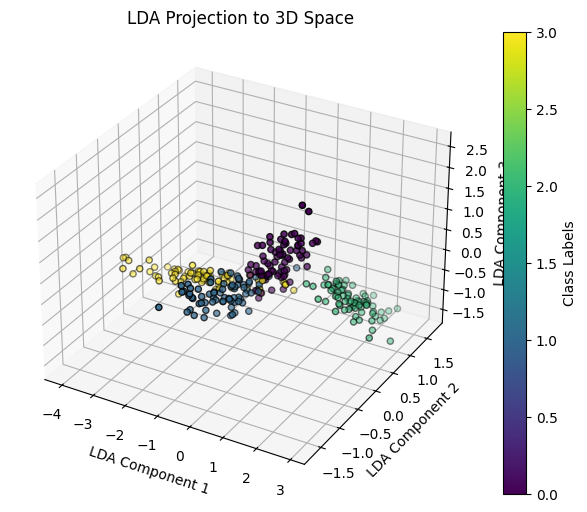

In [83]:
# Visulaize the projected data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_projected[:, 0], X_projected[:, 1], X_projected[:, 2], c=y_train, cmap='viridis', edgecolor='k')

ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
plt.colorbar(scatter, label="Class Labels")
plt.title("LDA Projection to 3D Space")
plt.show()

## Run On Customer Bank Dataset

In [114]:
num_classes = len(np.unique(yc_train))
num_components = num_classes - 1
W = solve_lda(Xc_train, yc_train, num_classes, num_components)
print("W shape:", W.shape)

W shape: (20, 2)


In [115]:
Xc_projected = Xc_train @ W
Xc_projected

array([[ 2.12174883,  0.90510836],
       [-2.30068857,  0.66838014],
       [ 1.8283135 ,  0.09996797],
       ...,
       [ 0.36269737, -0.28729794],
       [ 1.76676074,  0.42955656],
       [ 2.41937854,  0.44301855]], shape=(42775, 2))

Classes: [0 1 2]


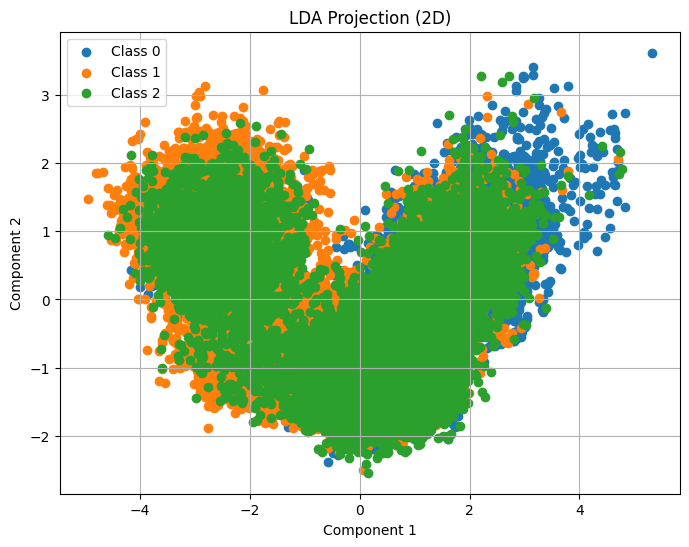

In [116]:
classes = np.unique(yc_train)
print("Classes:", classes)

plt.figure(figsize=(8, 6))
for cls in classes:
    plt.scatter(
        Xc_projected[yc_train == cls, 0],  # First component
        Xc_projected[yc_train == cls, 1],  # Second component
        label=f"Class {cls}"
    )

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("LDA Projection (2D)")
plt.legend()
plt.grid()
plt.show()